<a href="https://colab.research.google.com/github/lua1235/TornML/blob/main/Testbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Get Dataset From Google Sheets


In [34]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('Torn ML DataSet').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get('J2:CX')
rows[1:] = [[np.float64(i) for i in r] for r in rows[1:]]

view = pd.DataFrame(rows[1:], columns=rows[0])

# normalize
lMean = view['Stat Totals'].mean()
lStd = view['Stat Totals'].std()

fMean = view[view.columns[1:]].mean()
fMean = view[view.columns[1:]].std()

view = (view - view.mean())/view.std()
view = view.sample(frac=1, random_state=1)
labels = view['Stat Totals'].to_numpy()
features = view[view.columns[1:]].to_numpy()
print(view.shape)
print(labels.shape)
print(features.shape)

features = np.append(np.ones((len(features), 1)), features, 1) # append a column of 1s for bias term



(178, 93)
(178,)
(178, 92)


# Learners
Using squared loss

##Batch ERM

In [4]:
# X - (n, d+1) matrix of features
# Y - (n, 1) vector of labels

def batch_erm_learner(X, y, step_function, random_seed = 1, epochs = 10) :
  n, d = np.shape(X)
  w = np.random.default_rng(random_seed).random(d) # random weight initialization

  for i in range(epochs) :
    gradient = (2/n) * (X.T @ (X @ w - y))
    w = w - step_function(i) * gradient

  # x - (d, 1) vector of features
  def predictor(x) :
    return x @ w

  return predictor, w

#Training and Testing

## Dataset splitting

In [35]:
# split the dataset into training and testing set
n = len(features)
train_features = features[:(n + 1) // 2]
train_labels = labels[:(n + 1) // 2]
train_n = len(train_features)

test_features = features[(n + 1) // 2:]
test_labels = labels[(n + 1) // 2:]
test_n = len(train_features)

def loss(a) :
    return 0.01


## Epoch Comparision

    epochs  training error  testing error
0        0      376.185007    1167.729910
1      100        0.322962      34.978393
2      200        0.145079      30.329252
3      300        0.088461      27.367084
4      400        0.063334      25.154421
..     ...             ...            ...
95    9500        0.003301       4.483675
96    9600        0.003267       4.437027
97    9700        0.003234       4.391042
98    9800        0.003202       4.345708
99    9900        0.003170       4.301013

[100 rows x 3 columns]


<Axes: xlabel='epochs'>

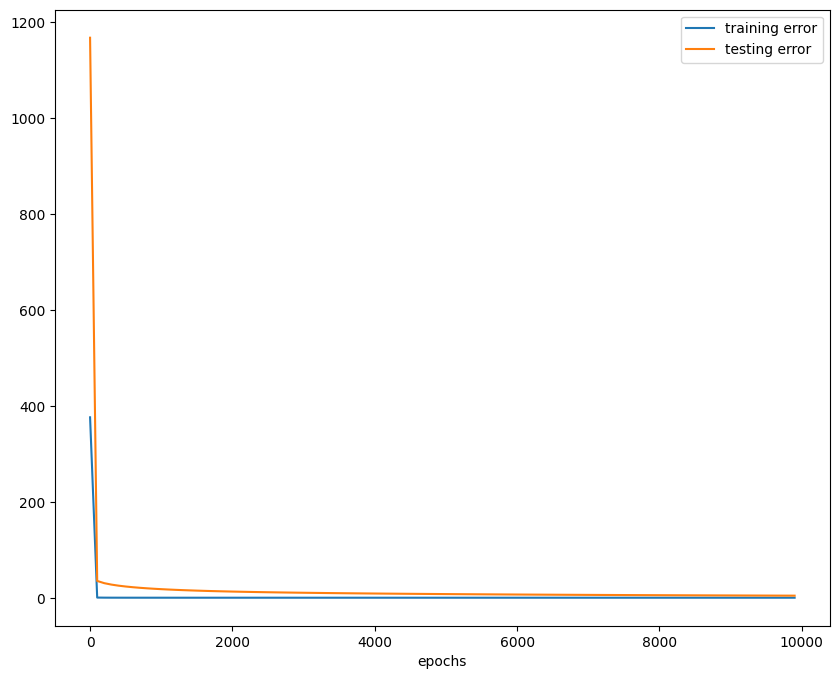

In [36]:
errors = {'epochs' : [], 'training error' : [], 'testing error' : []}

for i in range(0, 10000, 100) :
  batch_erm_f, batch_erm_w = batch_erm_learner(train_features, train_labels, loss, epochs = i)
  #print(batch_erm_w)
  #print(batch_erm_f(train_features[0]))
  train_error = (1/train_n) * sum([(batch_erm_f(x) - y) ** 2 for x, y in zip(train_features, train_labels)])
  test_error = (1/test_n) * sum([(batch_erm_f(x) - y) ** 2 for x, y in zip(test_features, test_labels)])
  errors['epochs'].append(i)
  errors['training error'].append(train_error)
  errors['testing error'].append(test_error)

errors = pd.DataFrame(errors)
print(errors)
errors.plot(figsize=(10, 8), x='epochs', y=['training error', 'testing error'])




# Denormalized Results

    index  Actual Stat Total  Predicted Stat Total
0       0       9.609889e+08         -3.341858e+08
1       1       6.499490e+05         -2.499546e+08
2       2       4.829629e+09          4.057439e+09
3       3       6.415788e+08          1.282162e+09
4       4       1.596845e+07          5.846470e+08
..    ...                ...                   ...
84     84       2.298723e+09          2.834487e+09
85     85       1.425287e+09          1.003845e+09
86     86       1.281295e+08          6.289471e+08
87     87       1.500085e+09          9.570039e+08
88     88       3.848671e+06          1.591528e+08

[89 rows x 3 columns]
    index  Actual Stat Total  Predicted Stat Total
0       0       1.773305e+09          1.846522e+09
1       1       5.893936e+07          8.736063e+07
2       2       7.165037e+08          6.949569e+08
3       3       2.926036e+08          3.420411e+08
4       4       2.609948e+09          2.585154e+09
..    ...                ...                   ...
84     8

<Axes: title={'center': 'Train Error'}, xlabel='index'>

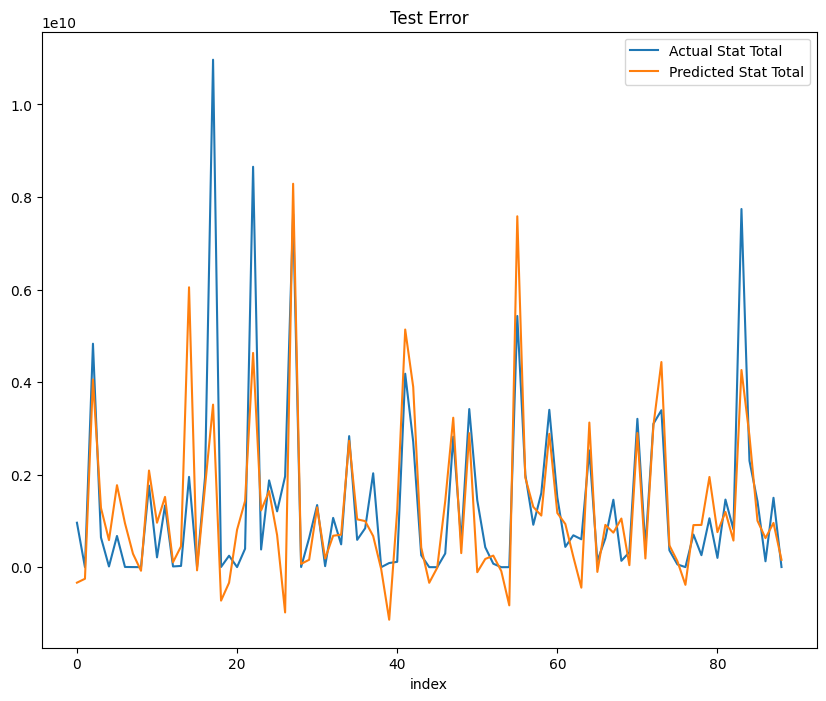

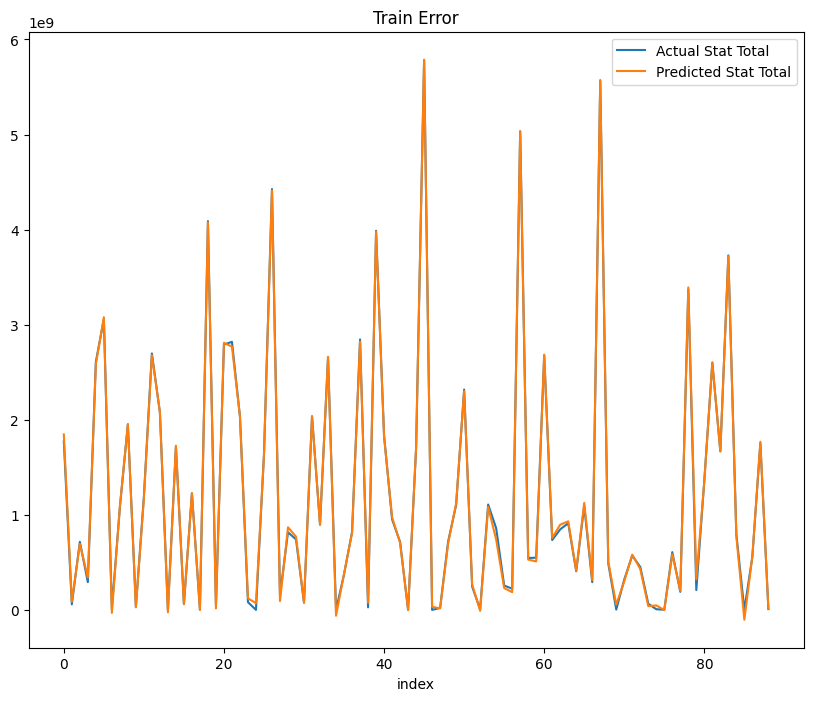

In [37]:
batch_erm_f, batch_erm_w = batch_erm_learner(train_features, train_labels, loss, epochs = 100000)

test_error = {'index' : [], 'Actual Stat Total' : [], 'Predicted Stat Total' : []}

for i, v in enumerate(test_features) :
  test_error['index'].append(i)
  act = lMean + lStd * test_labels[i]
  test_error['Actual Stat Total'].append(act)
  prd = lMean + lStd * batch_erm_f(v)
  test_error['Predicted Stat Total'].append(prd)

test_error = pd.DataFrame(test_error)
print(test_error)
test_error.plot(figsize=(10, 8), x='index', y=['Actual Stat Total', 'Predicted Stat Total'], title='Test Error')


train_error = {'index' : [], 'Actual Stat Total' : [], 'Predicted Stat Total' : []}

for i, v in enumerate(train_features) :
  train_error['index'].append(i)
  act = lMean + lStd * train_labels[i]
  train_error['Actual Stat Total'].append(act)
  prd = lMean + lStd * batch_erm_f(v)
  train_error['Predicted Stat Total'].append(prd)

train_error = pd.DataFrame(train_error)
print(train_error)
train_error.plot(figsize=(10, 8), x='index', y=['Actual Stat Total', 'Predicted Stat Total'], title='Train Error')





